# Fitting ARIMA models to housing prices
This notebook fits ARIMA models to the RedFin housing price data. The idea is to fit a different model to each region and use this to make forecasts.

Fitting is done using [pmdarima Python library](), which which uses MLE fitting to tune parameters to data, usual stationary testing (ala augmented Dickey-Fuller) to determine integration order, and stepwise AIC to determine the number of leads and lags. This allows us to fit models automatically, without needing a train/validate split or cross-validation.

The long-term predictions of an ARIMA model will simply tend toward some mean value, or equilibrium trend. I also fit a model which predicts one step ahead (not discussed for time in the main presentation) which has much better performance, but is rolling-full-sample (as opposed to the COVID period being truly out-of-sample).

This script accomplishes two goals:
* It organizes the housing data and fits ARIMA models to each county, as well as computes the predictions.
* It then constructs visualizations with the results.

The first step can be skipped and results loaded from a local CSV file. The only visualization that will be impacted will be the model order histogram (the pmd model objects are harder to save down).

## Setup

In [1]:
# Packages
import pandas as pd, pmdarima as pm, numpy as np
import time
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn', turns off some annoying pandas warnings

In [2]:
# Useful constants

# File location -- update as appropriate
DATA_DIR = 'C:\\Users\\Michael\\Documents\\JHU EP\\625.742 - Theory of Machine Learning\\Project\\'

# Date ranges for tuing model and predictions
OOS_DATE = '12/1/2019'
COVID_START = '3/1/2020'

# Data cleaning parameter: minimum housing price
MIN_HOME_PRICE = 25000

## Loading the housing data

In [3]:
# Load the raw housing data
home_data = pd.read_csv(f"{DATA_DIR}combined_home_data.csv")
home_data.head()

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,169,245,284,288,292,304,308,312,348,352,356) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,region_id,period_begin,period_end,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,...,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
0,525,2019-05-20,2019-06-16,141.0,0.060150,35.0,0.060606,41.0,0.640000,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
1,525,2019-05-27,2019-06-23,148.0,0.129771,37.0,0.156250,40.0,0.818182,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
2,525,2019-05-13,2019-06-09,152.0,0.169231,38.0,0.187500,43.0,0.433333,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
3,525,2019-05-06,2019-06-02,149.0,0.182540,37.0,0.193548,39.0,0.344828,9.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
4,525,2020-01-20,2020-02-16,105.0,0.153846,26.0,0.181818,35.0,0.346154,8.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5


In [4]:
# Subset to the need columns and remove NaNs
home_price_data = home_data[['state_code','county_name','region_id','period_begin','median_sale_price']].dropna()

In [5]:
# Filter data to remove counties where the housing prices are unrealistically low
low_price_regions = np.unique(home_price_data.loc[home_price_data['median_sale_price'] < MIN_HOME_PRICE,'region_id'].values)
all_regions = np.unique(home_price_data['median_sale_price'].values)
print(low_price_regions.size)

if False:
    with open('low_price_regions.txt', 'w') as f:
        for reg in low_price_regions:
            f.write("%d\n" % reg)
            
print(home_price_data.loc[home_price_data['region_id'].isin(low_price_regions),:].size/home_price_data.size)

196
0.09397124795067657


## Example: fitting Howard County, MD housing prices
This code generates the example model shown in the presentation, which shows the ARIMA results for Howard County, Maryland.

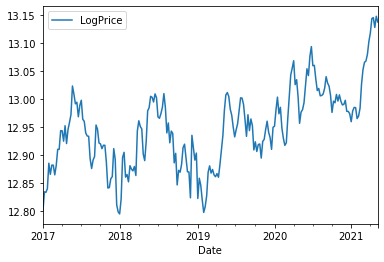

In [6]:
# To start, plot the data
my_state = 'MD'
my_county = 'Howard County'

my_data = home_price_data.loc[(home_price_data['state_code']==my_state) & (home_price_data['county_name']==my_county),:]
my_data['Date'] = pd.to_datetime(my_data['period_begin'])
my_data['LogPrice'] = np.log(my_data['median_sale_price'])

my_data = my_data[['Date','LogPrice']].set_index('Date').sort_index()
my_data.plot()

In [7]:
# Fit a fixed-space date grid to the data
date_grid = pd.date_range(start=my_data.index[0],end=my_data.index[-1],freq='7D')
date_grid = pd.DataFrame(date_grid,columns={'Date'}).set_index('Date')
aligned_data, _ = my_data.align(date_grid, method='pad')
aligned_data.head()

,LogPrice
Date,
2017-01-02,12.800055
2017-01-09,12.834014
2017-01-16,12.833013
2017-01-23,12.839669
2017-01-30,12.885058


In [8]:
# Train the data using the period prior to the OOS period and show the details
train_data = aligned_data .loc[aligned_data.index <= OOS_DATE,:]
my_model = pm.auto_arima(train_data)
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  152
Model:               SARIMAX(2, 0, 4)   Log Likelihood                 369.437
Date:                Sun, 08 Aug 2021   AIC                           -722.875
Time:                        14:15:35   BIC                           -698.684
Sample:                             0   HQIC                          -713.048
                                - 152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0075      0.863      1.168      0.243      -0.684       2.699
ar.L1          0.7832      0.154      5.085      0.000       0.481       1.085
ar.L2          0.1387      0.116      1.200      0.230      -0.088       0.365
ma.L1          0.2682      0.146      1.840      0.066      -0.018       0.554
ma.L2          0.2410      0.115      2.089      0.037       0.015       0.467
ma.L3          0.1736      0.124      1.397      0.162      -0.070       0.417
ma.L4         -0.7126      0.128     -5.547      0.000      -0.964      -0.461
sigma2         0.0004   4.42e-05      9.649      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.70
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.21   Skew:                             0.16
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Calculate the ARIMA forecasts

# Fill in in-sample predictions and true OOS n-step-ahead predictions
fit_data = aligned_data.copy(deep=True)
fit_data.loc[fit_data.index <= OOS_DATE, 'Prediction'] = my_model.predict_in_sample()
fit_data.loc[fit_data.index > OOS_DATE, 'Prediction'] = my_model.predict(sum([1 for v in fit_data.index > OOS_DATE if v]))

# Do the rolling (one-step-ahead) update
test_data = aligned_data[aligned_data.index > OOS_DATE]
for t in test_data.index:
    # Make the prediction
    test_data.loc[t,'Rolling Prediction'] = my_model.predict(n_periods=1)        
    # Add the actual value to the model and re-fit
    my_model.update(test_data.loc[t,'LogPrice'])

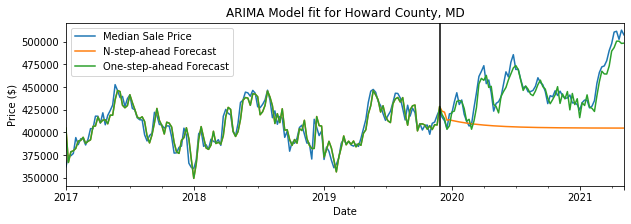

In [10]:
# Compare the predictions and plot
fit_data['Rolling Prediction'] = fit_data['Prediction']
fit_data.loc[fit_data.index>=test_data.index[0],'Rolling Prediction'] = test_data['Rolling Prediction']
fit_data[['Median Sale Price','N-step-ahead Forecast','One-step-ahead Forecast']] =  fit_data[['LogPrice','Prediction','Rolling Prediction']]
np.exp(fit_data[['Median Sale Price','N-step-ahead Forecast','One-step-ahead Forecast']] ).plot(figsize=(10,3))
plt.title('ARIMA Model fit for Howard County, MD')
plt.ylabel('Price ($)')
plt.axvline(x='2019-12-01',color='k')

## Fitting to all counties (takes a few hours, can be skipped and loaded from file)

In [11]:
def get_arima_predictions(data, oos_date = OOS_DATE, fit_log=True):
    """ Main helper for fitting ARIMA model predictions. Similar to example above, fits
        a full-sample prediction and also does one-step-ahead predictions. Designed to be
        called on a given county / region id at a time. Returns a pandas data frame with the
        predicted values.
        
        Returns the out-of-sample predictions, one-step-ahead predictions, as well as the
        fitted model object.
    """
    # Fix the date and sort
    ord_data = data.copy(deep=True)
    ord_data['Date'] = pd.to_datetime(ord_data['period_begin'])
    ord_data = ord_data.set_index('Date').sort_index()
    ord_data['Input'] = ord_data['median_sale_price']
    if fit_log:
        ord_data['Input'] = np.log(ord_data['Input'])

    # Create a uniform date grid
    date_grid = pd.date_range(start=ord_data.index[0],end=ord_data.index[-1],freq='7D')
    date_grid = pd.DataFrame(date_grid,columns={'Date'}).set_index('Date')
    aligned_data, _ = ord_data.align(date_grid, method='pad')
    aligned_data = aligned_data[['period_begin','Input']]

    # Fit the base model
    is_data = aligned_data.loc[aligned_data.index < oos_date,['Input']]
    auto_model = pm.auto_arima(is_data)
    auto_model.summary()

    # Calculate the long-term prediction
    n_is = sum([1 for v in aligned_data.index < oos_date if v])
    n_oos = sum([1 for v in aligned_data.index >= oos_date if v])
    aligned_data.loc[aligned_data.index[range(n_is)],'Prediction'] = auto_model.predict_in_sample()
    aligned_data.loc[aligned_data.index[range(n_is,n_is+n_oos)],'Prediction']  = auto_model.predict(n_oos)

    # Calculate the rolling predictions
    aligned_data['Rolling Prediction'] = aligned_data['Prediction']
    for t in range(n_is,n_is+n_oos):
        ti = aligned_data.index[t]
        aligned_data.loc[ti,'Rolling Prediction'] = auto_model.predict(1)
        auto_model.update(aligned_data.loc[ti,'Input'])

    # Replace zeros with NaNs to deal with integrated models starting at zero
    aligned_data['Prediction'] = aligned_data['Prediction'].replace({0:np.nan})
    aligned_data['Rolling Prediction'] = aligned_data['Rolling Prediction'].replace({0:np.nan})

    # Undo the log transformation
    if fit_log:
        aligned_data[['Input','Prediction','Rolling Prediction']] = np.exp(aligned_data[['Input','Prediction','Rolling Prediction']])

    # Remove the first row (which is in-sample anyway) to deal with warmup issues
    return aligned_data.iloc[1:,:], auto_model
    

In [12]:
# Main task -- fit ARIMA model to each region (takes several hours)
allRegIds = np.unique(home_price_data['region_id'].values)

# Initialize objects to store information
counter = 1
badRegIds = []
allModels = {}
arimaResults  = pd.DataFrame()

for regId in allRegIds:
    print("Working on region_id %d (%d of %d)" % (regId, counter, len(allRegIds)))
    start = time.time()
    
    try:
        # Filter the data
        regLoc = home_price_data['region_id'] == regId
        regData = home_price_data.loc[regLoc,['period_begin','median_sale_price']]
        # Fit the ARIMA model
        regArima, fittedModel = get_arima_predictions(regData)
        allModels[regId] = fittedModel
        regArima['region_id'] = regId
        arimaResults = arimaResults.append(regArima)
        
    except Exception as e:
        print('Error occured: ' + str(e))
        badRegIds = badRegIds + [regId]
        pass 
    
    end = time.time()
    counter = counter+1
    print('...finished in %d seconds, moving on' % (end-start))

Working on region_id 2 (1 of 1697)
...finished in 19 seconds, moving on
Working on region_id 118 (2 of 1697)
...finished in 10 seconds, moving on
Working on region_id 122 (3 of 1697)
...finished in 9 seconds, moving on
Working on region_id 123 (4 of 1697)
...finished in 15 seconds, moving on
Working on region_id 126 (5 of 1697)
...finished in 11 seconds, moving on
Working on region_id 128 (6 of 1697)
...finished in 14 seconds, moving on
Working on region_id 129 (7 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 132 (8 of 1697)
...finished in 5 seconds, moving on
Working on region_id 133 (9 of 1697)
...finished in 5 seconds, moving on
Working on region_id 137 (10 of 1697)
...finished in 5 seconds, moving on
Working on region_id 140 (11 of 1697)
...finished in 16 seconds, moving on
Working on region_id 143 (12 of 1697)
...finished in 8 seconds, moving on
Working on region_id 146 (13 of 1697)
...finished in 2 seconds, moving on
Working on region_id 154 (14 of 1697)
...finished in 16 seconds, moving on
Working on region_id 155 (15 of 1697)
...finished in 3 seconds, moving on
Working on region_id 158 (16 of 1697)
...finished in 14 seconds, moving on
Working on region_id 160 (17 of 1697)
...finished in 2 seconds, moving on
Working on region_id 163 (18 of 1697)
...finished in 24 seconds, moving on
Working on region_id 166 (19 of 1697)
...finished in 2 seconds, moving on
Working on region_id 170 (20 of 1697)
...finished in 2 seconds, moving on


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 1 seconds, moving on
Working on region_id 260 (57 of 1697)
...finished in 10 seconds, moving on
Working on region_id 262 (58 of 1697)
...finished in 7 seconds, moving on
Working on region_id 265 (59 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 267 (60 of 1697)
...finished in 8 seconds, moving on
Working on region_id 270 (61 of 1697)
...finished in 2 seconds, moving on
Working on region_id 271 (62 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 273 (63 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 274 (64 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 275 (65 of 169

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountere

...finished in 2 seconds, moving on
Working on region_id 276 (66 of 1697)
...finished in 7 seconds, moving on
Working on region_id 280 (67 of 1697)
...finished in 7 seconds, moving on
Working on region_id 282 (68 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 284 (69 of 1697)
...finished in 12 seconds, moving on
Working on region_id 285 (70 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 287 (71 of 1697)
...finished in 9 seconds, moving on
Working on region_id 288 (72 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 289 (73 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 2 seconds, moving on
Working on region_id 301 (84 of 1697)
...finished in 1 seconds, moving on
Working on region_id 302 (85 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 303 (86 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 21 seconds, moving on
Working on region_id 304 (87 of 1697)
...finished in 3 seconds, moving on
Working on region_id 305 (88 of 1697)
...finished in 2 seconds, moving on
Working on region_id 306 (89 of 1697)
...finished in 12 seconds, moving on
Working on region_id 307 (90 of 1697)
...finished in 7 seconds, moving on
Working on region_id 308 (91 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 309 (92 of 1697)
...finished in 18 seconds, moving on
Working on region_id 311 (93 of 1697)
...finished in 12 seconds, moving on
Working on region_id 312 (94 of 1697)
...finished in 8 seconds, moving on
Working on region_id 313 (95 of 1697)
...finished in 14 seconds, moving on
Working on region_id 317 (96 of 1697)
...finished in 18 seconds, moving on
Working on region_id 319 (97 of 1697)
...finished in 13 seconds, moving on
Working on region_id 321 (98 of 1697)
...finished 

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 461 (189 of 1697)
...finished in 2 seconds, moving on
Working on region_id 462 (190 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 464 (191 of 1697)
...finished in 15 seconds, moving on
Working on region_id 466 (192 of 1697)
...finished in 2 seconds, moving on
Working on region_id 468 (193 of 1697)
...finished in 1 seconds, moving on
Working on region_id 470 (194 of 1697)
...finished in 21 seconds, moving on
Working on region_id 471 (195 of 1697)
...finished in 15 seconds, moving on
Working on region_id 472 (196 of 1697)
...finished in 2 seconds, moving on
Working on region_id 473 (197 of 1697)
...finished in 3 seconds, moving on
Working on region_id 474 (198 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 475 (199 of 1697)
...finished in 13 seconds, moving on
Working on region_id 476 (200 of 1697)
...finished in 3 seconds, moving on
Working on region_id 477 (201 of 1697)
...finished in 1 seconds, moving on
Working on region_id 478 (202 of 1697)
...finished in 2 seconds, moving on
Working on region_id 479 (203 of 1697)
...finished in 26 seconds, moving on
Working on region_id 481 (204 of 1697)
...finished in 11 seconds, moving on
Working on region_id 482 (205 of 1697)
...finished in 2 seconds, moving on
Working on region_id 483 (206 of 1697)
...finished in 19 seconds, moving on
Working on region_id 484 (207 of 1697)
...finished in 17 seconds, moving on
Working on region_id 485 (208 of 1697)
...finished in 3 seconds, moving on
Working on region_id 486 (209 of 1697)
...finished in 9 seconds, moving on
Working on region_id 487 (210 of 1697)
...finished in 9 seconds, moving on
Working on region_id 488 (211 of 1697)
...finished in 14 se

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountere

...finished in 11 seconds, moving on
Working on region_id 509 (229 of 1697)
...finished in 11 seconds, moving on
Working on region_id 510 (230 of 1697)
...finished in 21 seconds, moving on
Working on region_id 511 (231 of 1697)
...finished in 16 seconds, moving on
Working on region_id 512 (232 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 513 (233 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 514 (234 of 1697)
...finished in 3 seconds, moving on
Working on region_id 515 (235 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 516 (236 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 517 (237 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 518 (238 of 1697)
...finished in 9 seconds, moving on
Working on region_id 519 (239 of 1697)
...finished in 3 seconds, moving on
Working on region_id 520 (240 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountere

...finished in 0 seconds, moving on
Working on region_id 521 (241 of 1697)
...finished in 16 seconds, moving on
Working on region_id 523 (242 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 524 (243 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 525 (244 of 1697)
...finished in 2 seconds, moving on
Working on region_id 526 (245 of 1697)
...finished in 2 seconds, moving on
Working on region_id 527 (246 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 528 (247 of 1697)
...finished in 29 seconds, moving on
Working on region_id 530 (248 of 1697)
...finished in 1 seconds, moving on
Working on region_id 531 (249 of 1697)
...finished in 27 seconds, moving on
Working on region_id 532 (250 of 1697)
...finished in 1 seconds, moving on
Working on region_id 534 (251 of 1697)
...finished in 13 seconds, moving on
Working on region_id 535 (252 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) wh

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 539 (255 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 540 (256 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 541 (257 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 9 seconds, moving on
Working on region_id 542 (258 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 543 (259 of 1697)
...finished in 1 seconds, moving on
Working on region_id 544 (260 of 1697)
...finished in 16 seconds, moving on
Working on region_id 545 (261 of 1697)
...finished in 21 seconds, moving on
Working on region_id 546 (262 of 1697)
...finished in 1 seconds, moving on
Working on region_id 547 (263 of 1697)
...finished in 16 seconds, moving on
Working on region_id 548 (264 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 549 (265 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 550 (266 of 1697)
...finished in 1 seconds, moving on
Working on region_id 551 (267 of 1697)
...finished in 2 seconds, moving on
Working on region_id 552 (268 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 554 (269 of 1697)
...finished in 25 seconds, moving on
Working on region_id 555 (270 of 1697)
...finished in 1 seconds, moving on
Working on region_id 556 (271 of 1697)
...finished in 1 seconds, moving on
Working on region_id 557 (272 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 558 (273 of 1697)
...finished in 9 seconds, moving on
Working on region_id 559 (274 of 1697)
...finished in 2 seconds, moving on
Working on region_id 560 (275 of 1697)
...finished in 15 seconds, moving on
Working on region_id 561 (

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 585 (299 of 1697)
...finished in 1 seconds, moving on
Working on region_id 586 (300 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 587 (301 of 1697)
...finished in 1 seconds, moving on
Working on region_id 588 (302 of 1697)
...finished in 1 seconds, moving on
Working on region_id 589 (303 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 590 (304 of 1697)
...finished in 3 seconds, moving on
Working on region_id 591 (305 of 1697)
...finished in 1 seconds, moving on
Working on region_id 592 (306 of 1697)
...finished in 1 seconds, moving on
Working on region_id 593 (307 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 599 (313 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 600 (314 of 1697)
...finished in 2 seconds, moving on
Working on region_id 601 (315 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 602 (316 of 1697)
...finished in 7 seconds, moving on
Working on region_id 603 (317 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 604 (318 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountere

...finished in 1 seconds, moving on
Working on region_id 605 (319 of 1697)
...finished in 3 seconds, moving on
Working on region_id 606 (320 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 607 (321 of 1697)
...finished in 7 seconds, moving on
Working on region_id 608 (322 of 1697)
...finished in 5 seconds, moving on
Working on region_id 609 (323 of 1697)
...finished in 3 seconds, moving on
Working on region_id 610 (324 of 1697)
...finished in 2 seconds, moving on
Working on region_id 611 (325 of 1697)
...finished in 4 seconds, moving on
Working on region_id 612 (326 of 1697)
...finished in 6 seconds, moving on
Working on region_id 613 (327 of 1697)
...finished in 23 seconds, moving on
Working on region_id 614 (328 of 1697)
...finished in 3 seconds, moving on
Working on region_id 615 (329 of 1697)
...finished in 21 seconds, moving on
Working on region_id 616 (330 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 617 (331 of 1697)
...finished in 13 seconds, moving on
Working on region_id 618 (332 of 1697)
...f

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 620 (334 of 1697)
...finished in 9 seconds, moving on
Working on region_id 621 (335 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 622 (336 of 1697)
...finished in 3 seconds, moving on
Working on region_id 624 (337 of 1697)
...finished in 11 seconds, moving on
Working on region_id 625 (338 of 1697)
...finished in 2 seconds, moving on
Working on region_id 627 (339 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 628 (340 of 1697)
...finished in 1 seconds, moving on
Working on region_id 629 (341 of 1697)
...finished in 10 seconds, moving on
Working on region_id 630 (342 of 1697)
...finished in 1 seconds, moving on
Working on region_id 632 (343 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 633 (344 of 1697)
...finished in 1 seconds, moving on
Working on region_id 634 (345 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 635 (346 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 636 (347 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 637 (348 of 1697)
...finished in 1 seconds, moving on
Working on region_id 638 (349 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 639 (350 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 1 seconds, moving on
Working on region_id 640 (351 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 641 (352 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 642 (353 of 1697)
...finished in 1 seconds, moving on
Working on region_id 643 (354 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 644 (355 of 1697)
...finished in 2 seconds, moving on
Working on region_id 646 (356 of 1697)
...finished in 2 seconds, moving on
Working on region_id 647 (357 of 1697)
...finished in 3 seconds, moving on
Working on region_id 648 (358 of 1697)
...finished in 8 seconds, moving on
Working on region_id 649 (359 of 1697)
...finished in 2 seconds, moving on
Working on region_id 650 (360 of 1697)
...finished in 17 seconds, moving on
Working on region_id 651 (361 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 652 (362 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 653 (363 of 1697)
...finished in 1 seconds, moving on
Working on region_id 654 (364 of 1697)
...finished in 1 seconds, moving on
Working on region_id 655 (365 of 1697)
...finished in 0 seconds, moving on
Working on region_id 656 (366 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 657 (367 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 2 seconds, moving on
Working on region_id 658 (368 of 1697)
...finished in 3 seconds, moving on
Working on region_id 659 (369 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 660 (370 of 1697)
...finished in 1 seconds, moving on
Working on region_id 661 (371 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 662 (372 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 663 (373 of 1697)
...finished in 2 seconds, moving on
Working on region_id 664 (374 of 1697)
...finished in 18 seconds, moving on
Working on region_id 666 (375 of 1697)
...finished in 1 seconds, moving on
Working on region_id 667 (376 of 1697)
...finished in 2 seconds, moving on
Working on region_id 668 (377 of 1697)
...finished in 23 seconds, moving on
Working on region_id 669 (378 of 1697)
...finished in 1 seconds, moving on
Working on region_id 671 (379 of 1697)
...finished in 3 seconds, moving on
Working on region_id 672 (380 of 1697)
...finished in 7 seconds, moving on
Working on region_id 675 (381 of 1697)
...finished in 4 seconds, moving on
Working on region_id 676 (382 of 1697)
...finished in 2 seconds, moving on
Working on region_id 678 (383 of 1697)
...finished in 9 seconds, moving on
Working on region_id 680 (384 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...fi

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 683 (387 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 685 (388 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 687 (389 of 1697)
...finished in 1 seconds, moving on
Working on region_id 688 (390 of 1697)
...finished in 3 seconds, moving on
Working on region_id 690 (391 of 1697)
...finished in 7 seconds, moving on
Working on region_id 691 (392 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 692 (393 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 694 (394 of 1697)
Error occured: Found array w

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 25 seconds, moving on
Working on region_id 709 (406 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 710 (407 of 1697)
...finished in 1 seconds, moving on
Working on region_id 711 (408 of 1697)
...finished in 18 seconds, moving on
Working on region_id 714 (409 of 1697)
...finished in 10 seconds, moving on
Working on region_id 715 (410 of 1697)
...finished in 2 seconds, moving on
Working on region_id 717 (411 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 718 (412 of 1697)
...finished in 6 seconds, moving on
Working on region_id 721 (413 of 1697)
...finished in 2 seconds, moving on
Working on region_id 725 (414 of 1697)
...finished in 1 seconds, moving on
Working on region_id 727 (415 of 1697)
...finished in 10 seconds, moving on
Working on region_id 730

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 770 (435 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 771 (436 of 1697)
...finished in 13 seconds, moving on
Working on region_id 773 (437 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 778 (438 of 1697)
...finished in 2 seconds, moving on
Working on region_id 779 (439 of 1697)
...finished in 2 seconds, moving on
Working on region_id 782 (440 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 785 (441 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 789 (442 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 790 (443 of 1697)
...finished in 2 seconds, moving on
Working on region_id 793 (444 of 1697)
...finished in 2 seconds, moving on
Working on region_id 800 (445 of 1697)
...finished in 12 seconds, moving on
Working on region_id 806 (446 of 1697)
...finished in 7 seconds, moving on
Working on region_id 809 (447 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 810 (448 of 1697)
...finished in 9 seconds, moving on
Working on region_id 812 (449 of 1697)
...finished in 12 seconds, moving on
Working 

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 852 (461 of 1697)
...finished in 1 seconds, moving on
Working on region_id 853 (462 of 1697)
...finished in 2 seconds, moving on
Working on region_id 854 (463 of 1697)
...finished in 2 seconds, moving on
Working on region_id 861 (464 of 1697)
...finished in 14 seconds, moving on
Working on region_id 862 (465 of 1697)
...finished in 15 seconds, moving on
Working on region_id 867 (466 of 1697)
...finished in 15 seconds, moving on
Working on region_id 868 (467 of 1697)
...finished in 2 seconds, moving on
Working on region_id 871 (468 of 1697)
...finished in 6 seconds, moving on
Working on region_id 880 (469 of 1697)
...finished in 1 seconds, moving on
Working on region_id 882 (470 of 1697)
...finished in 2 seconds, moving on
Working on region_id 883 (471 of 1697)
...finished in 12 seconds, moving on
Working on region_id 886 (472 of 1697)
...finished in 1 seconds, moving on
Working on region_id 891 (473 of 1697)
...finished in 10 sec

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1238 (557 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1243 (558 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1245 (559 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1246 (560 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1248 (561 of 1697)
...finished in 11 seconds, moving on
Working on region_id 1253 (562 of 1697)
...finished in 10 seconds, moving on
Working on region_id 1255 (563 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1261 (564 of 1697)
...finished in 13 seconds, moving on
Working on region_id 1265 (565 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1267 (566 of 1697)
...finished in 9 seconds, moving on
Working on region_id 1268 (567 of 1697)
...finished in 4 seconds, moving on
Working on region_id 1273 (568 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1274 (569 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1275 (570 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1276 (571 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1277 (572 of 1697)
...finish

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 1340 (623 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1341 (624 of 1697)
...finished in 10 seconds, moving on
Working on region_id 1342 (625 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1343 (626 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1344 (627 of 1697)
...finished in 8 seconds, moving on
Working on region_id 1345 (628 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1346 (629 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1347 (630 of 1697)
...finished in 15 seconds, moving on
Working on region_id 1350 (631 of 1697)
...finished in 9 seconds, moving on
Working on region_id 1355 (632 of 1697)
...finished in 8 seconds, moving on
Working on region_id 1356 (633 of 1697)
...finished in 6 seconds, moving on
Working on region_id 1358 (634 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1359 (635 of 1697)
...finishe

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 1366 (639 of 1697)
...finished in 8 seconds, moving on
Working on region_id 1370 (640 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1372 (641 of 1697)
...finished in 14 seconds, moving on
Working on region_id 1373 (642 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1376 (643 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1377 (644 of 1697)
...finished in 12 seconds, moving on
Working on region_id 1379 (645 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1380 (646 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1381 (647 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1385 (648 of 1697)
...finished in 13 seconds, moving on
Working on region_id 1386 (649 of 1697)
...finished in 13 seconds, moving on
Working on region_id 1388 (650 of 1697)
...finished in 18 seconds, moving on
Working on region_id 1390 (651 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1391 (652 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1393 (653 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1394 (654 of 1697)
...finished in 17 seconds, moving on
Working on region_id 1397 (655 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1398 (656 of 1697)
...finished in 4 seconds, moving on
Working on region_id 1400 (657 of 1697)
...finished in 9 seconds, moving on
Working on region_id 1401 (658 of 1697)
...finis

...finished in 18 seconds, moving on
Working on region_id 1508 (754 of 1697)
...finished in 6 seconds, moving on
Working on region_id 1509 (755 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1510 (756 of 1697)
...finished in 7 seconds, moving on
Working on region_id 1511 (757 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1512 (758 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1513 (759 of 1697)
...finished in 6 seconds, moving on
Working on region_id 1514 (760 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1515 (761 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1516 (762 of 1697)
...finished in 10 seconds, moving on
Working on region_id 1517 (763 of 1697)
...finished in 7 seconds, moving on
Working on region_id 1534 (764 of 1697)
...finished in 15 seconds, moving on
Working on region_id 1601 (765 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1606 (766 of 1697)
...finish

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1618 (773 of 1697)
...finished in 17 seconds, moving on
Working on region_id 1623 (774 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1624 (775 of 1697)
...finished in 15 seconds, moving on
Working on region_id 1627 (776 of 1697)
...finished in 7 seconds, moving on
Working on region_id 1630 (777 of 1697)
...finished in 6 seconds, moving on
Working on region_id 1631 (778 of 1697)
...finished in 4 seconds, moving on
Working on region_id 1632 (779 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1635 (780 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1636 (781 of 1697)
...finished in 12 seconds, moving on
Working on region_id 1646 (782 of 1697)
...finished in 4 seconds, moving on
Working on region_id 1647 (783 of 1697)
...finished in 17 seconds, moving on
Working on region_id 1649 (784 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1650 (785 of 1697)
...finis

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 1781 (814 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1782 (815 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1783 (816 of 1697)
...finished in 10 seconds, moving on
Working on region_id 1790 (817 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1797 (818 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1798 (819 of 1697)
...finished in 23 seconds, moving on
Working on region_id 1800 (820 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1804 (821 of 1697)
...finished in 8 seconds, moving on
Working on region_id 1818 (822 of 1697)
...finished in 1 seconds, moving on

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1837 (828 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1842 (829 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1846 (830 of 1697)
...finished in 11 seconds, moving on
Working on region_id 1847 (831 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1848 (832 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1850 (833 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1855 (834 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1859 (835 of 1697)
...finished in 25 s

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1869 (841 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1870 (842 of 1697)
...finished in 4 seconds, moving on
Working on region_id 1871 (843 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1872 (844 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1873 (845 of 1697)
...finished in 20 seconds, moving on
Working on region_id 1874 (846 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1875 (847 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1876 (848 of 1697)
...finished in 12 seconds, moving on
Working on region_id 1877 (849 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1878 (850 of 1697)
...finished in 19 seconds, moving on
Working on region_id 1879 (851 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1881 (852 of 1697)
...finished in 5 seconds, moving on
Working on region_id 1882 (853 of 1697)
...finish

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 1935 (888 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1937 (889 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 1938 (890 of 1697)
...finished in 17 seconds, moving on
Working on region_id 1940 (891 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 1942 (892 of 1697)
...finished in 1 seconds, moving on
Working on region_id 1944 (893 of 1697)
...finished in 8 seconds, moving on
Working on region_id 1945 (894 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1946 (895 of 1697)
...finished in 14 seconds, moving on
Working on region_id 1947 (896 of 1697)
...finished in 3 seconds, moving on
Working on region_id 1949 (897 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1950 (898 of 1697)
...finished in 21 seconds, moving on
Working on region_id 1951 (899 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1958 (900 of 1697)
...finished in 13 seconds, moving on
Working on region_id 1959 (901 of 1697)
...finished in 14 seconds, moving on
Working on region_id 1962 (902 of 1697)
...finished in 7 seconds, moving on
Working on region_id 1963 (903 of 1697)
...finished in 2 seconds, moving on
Working on region_id 1968 (904 of 1697)
...finis

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2017 (939 of 1697)
...finished in 13 seconds, moving on
Working on region_id 2018 (940 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2019 (941 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2020 (942 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2023 (943 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2024 (944 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2025 (945 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2026 (946 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 2028 (947 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2029 (948 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2035 (949 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2036 (950 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2038 (951 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2040 (952 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2041 (953 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2042 (954 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2044 (955 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2045 (956 of 1697)
...finished in 20 seconds, moving on
Working on region_id 2047 (957 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2049 (958 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2050 (959 of

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2064 (968 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2066 (969 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2067 (970 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2068 (971 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2069 (972 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2074 (973 of 1697)
...finished in 17 seconds, moving on
Working on region_id 2079 (974 of 1697)
...finished in 20 seconds, moving on
Working on region_id 2081 (975 of 1697)
...finished in 12 seconds, moving on
Working on region_id 2082 (976 of 1697)
...finished in 11 seconds, moving on
Working on region_id 2083 (977 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2085 (978 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2086 (979 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2087 (980 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2090 (981 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2091 (982 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2092 (983 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2093 (984 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2094 (985 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2096 (986 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2097 (987 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2098 (988 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2101 (989 

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2190 (1015 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2193 (1016 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2195 (1017 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2196 (1018 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2197 (1019 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2198 (1020 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2199 (1021 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2200 (1022 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2201 (1023 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2202 (1024 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2203 (1025 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2204 (1026 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2206 (1027 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2208 (1028 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2209 (1029 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2272 (1075 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2273 (1076 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2274 (1077 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 2275 (1078 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2277 (1079 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2278 (1080 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 3 seconds, moving on
Working on region_id 2279 (1081 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2280 (1082 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2281 (1083 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2282 (1084 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2283 (1085 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2284 (1086 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2285 (1087 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2286 (1088 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2287 (1089 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2288 (1090 of 1697)
...finished in 7 seconds, moving on
Working 

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2295 (1097 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2296 (1098 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2297 (1099 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2298 (1100 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2299 (1101 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2300 (1102 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2301 (1103 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2302 (1104 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2303 (1105 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2304 (1106 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2305 (1107 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2306 (1108 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2307 (1109 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2308 (1110 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2309 (1111 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2310 (1112 of 1697)
...finished in 11 seconds, moving on
Working on region_id 2311 (1113 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2312 (1114 of 16

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 2 seconds, moving on
Working on region_id 2329 (1130 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2330 (1131 of 1697)
...finished in 18 seconds, moving on
Working on region_id 2331 (1132 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2332 (1133 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2333 (1134 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2334 (1135 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2335 (1136 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2336 (1137 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2337 (1138 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2338 (1139 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2339 (1140 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2340 (1141 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2341 (1142 of 169

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2348 (1147 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2349 (1148 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2350 (1149 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2351 (1150 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2352 (1151 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2353 (1152 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2354 (1153 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2355 (1154 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2356 (1155 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2357 (1156 of 1697)
...finished in 20 seconds, moving on
Working on region_id 2358 (1157 of 1697)
...finished in 19 seconds, moving on
Working on region_id 

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2406 (1182 of 1697)
...finished in 18 seconds, moving on
Working on region_id 2408 (1183 of 1697)
...finished in 13 seconds, moving on
Working on region_id 2410 (1184 of 1697)
...finished in 21 seconds, moving on
Working on region_id 2411 (1185 of 1697)
...finished in 23 seconds, moving on
Working on region_id 2414 (1186 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2416 (1187 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2423 (1188 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2425 (1189 of 1697)
...finished in 20 seconds, moving on
Working on region_id 2427 (1190 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2428 (1191 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2429 (1192 of 1697)
...finished in 15 seconds, moving on
Working on region

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2464 (1227 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2465 (1228 of 1697)
...finished in 0 seconds, moving on
Working on region_id 2466 (1229 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2467 (1230 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2468 (1231 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2469 (1232 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2470 (1233 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2471 (1234 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2472 (1235 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2473 (1236 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2474 (1237 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2475 (1238 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2476 (1239 of 16

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2554 (1251 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2555 (1252 of 1697)
...finished in 13 seconds, moving on
Working on region_id 2556 (1253 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2557 (1254 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2558 (1255 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2559 (1256 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2560 (1257 of 1697)
...finished in 13 seconds, moving on
Working on region_id 2562 (1258 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2563 (1259 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2564 (1260 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2565 (1261 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2566 (1262 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2567 (1263 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2568 (1264 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2569 (1265 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2570 (1266 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2571 (1267 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2572 (1268 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2573 (1269 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2574 (1270 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2575 (1271 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2576 (1272 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2577 (1273 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2578 (1274 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2579 (1275 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2580 (1276 of 1697)
...finished in 24 seconds, moving on
Working on region_id 2581 (1277 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2582 (1278 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2583 (1279 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2584 (1280 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2585 (1281 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2586 (1282 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2587 (1283 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2588 (1284 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2589 (1285 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2590 (1286 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2591 (1287 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2593 (1288 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2594 (1289 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2595 (1290 of 1697)
...finished in 2 seconds, moving on
Working on region_id 25

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2614 (1308 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2615 (1309 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2616 (1310 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2617 (1311 of 1697)
...finished in 17 seconds, moving on
Working on region_id 2618 (1312 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2619 (1313 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2620 (1314 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2621 (1315 of 1697)
...finished in 11 seconds, moving on
Working on region_id 2622 (1316 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2623 (1317 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2624 (1318 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2625 (1319 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2626 (1320 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimu

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2631 (1325 of 1697)
...finished in 21 seconds, moving on
Working on region_id 2632 (1326 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2633 (1327 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2634 (1328 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2635 (1329 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2636 (1330 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2637 (1331 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2638 (1332 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2639 (1333 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2640 (1334 of 1697)
...finished in 2 seconds, moving on
Working

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2669 (1356 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2671 (1357 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


...finished in 0 seconds, moving on
Working on region_id 2673 (1358 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2675 (1359 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2676 (1360 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2678 (1361 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2680 (1362 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2681 (1363 of 1697)
...finished in 11 seconds, moving on
Working on region_id 2682 (1364 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2684 (1365 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2685 (1366 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2686 (1367 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2688 (1368 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2689 (1369 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2696 (1370 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2699 (1371 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2700 (1372 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2701 (1373 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2703 (1374 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2706 (1375 of

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2709 (1377 of 1697)
...finished in 17 seconds, moving on
Working on region_id 2710 (1378 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2711 (1379 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2712 (1380 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2713 (1381 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2714 (1382 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2715 (1383 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2718 (1384 of 1697)
...finished in 18 seconds, moving on
Working on region_id 2719 (1385 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2720 (1386 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2721 (1387 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2723 (1388 of 1697)
...finished in 15 seconds, moving on
Working on region_id 2725 (1389 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2727 (1390 of 1697)
...finished in 1 seconds, moving on
Workin

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2775 (1421 of 1697)
...finished in 13 seconds, moving on
Working on region_id 2776 (1422 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2777 (1423 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2778 (1424 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2780 (1425 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2781 (1426 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2782 (1427 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2783 (1428 of 1697)
...finished in 8 seconds, moving on
Working on region_id 2784 (1429 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2785 (1430 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2786 (1431 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2788 (1432 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2789 (1433 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2793 (1434 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2794 (1435 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2796 (1436 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2797 (1437 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2799 (1438 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2800 (1439 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2801 (1440 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2802 (1441 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2803 (1442 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 0 seconds, moving on
Working on region_id 2805 (1443 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 1 seconds, moving on
Working on region_id 2806 (1444 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2808 (1445 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2809 (1446 of 1697)
...finished in 16 seconds, moving on
Working on region_id 2811 (1447 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2813 (1448 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2814 (1449 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2816 (1450 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2817 (1451 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2820 (1452 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, m

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2829 (1457 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2832 (1458 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2833 (1459 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2835 (1460 of 1697)
...finished in 5 seconds, moving on
Working on region_id 2837 (1461 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2838 (1462 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2839 (1463 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2840 (1464 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished 

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3100: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3105: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 22 seconds, moving on
Working on region_id 2886 (1497 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2888 (1498 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2889 (1499 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2891 (1500 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2893 (1501 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2895 (1502 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2896 (1503 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2897 (1504 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2898 (1505 of 1697)
...finished in 9 seconds, moving on
Working on region_id 2899 (1506 of 1697)
...finished in 20 seconds, moving on
Working on region_id 2900 (1507 of 1697)
...finished in 19 seconds, moving on
Working on region_id 2901 (1508 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 2902 (1509 of 1697)
Error occured: Prediction must have `end` after `start`.
...finished in 1 seconds, moving on
Working on region_id 2903 (1510 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2904 (1511 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2905 (1512 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2906 (1513 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2907 (1514 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2908 (1515 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2910 (1516 of 1697)
...finished in 6 seconds, moving on
Working on region_id 2911 (1517 of 1697)
...finished in 21 seconds, moving on
Working on region_id 2912 (1518 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 2913 (1519 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2914 (1520 of 1697)
...finished in 1 seconds, moving on
Working on region_id 2915 (1521 of 1697)
...finished in 2 seconds, moving on
Working on region_id 2916 (1522 of 1697)
...finished in 10 seconds, moving on
Working on region_id 2917 (1523 of 1697)
...finished in 14 seconds, moving on
Working on region_id 2918 (1524 of 1697)
...finished in 3 seconds, moving on
Working on region_id 2919 (1525 of 1697)
...finished in 23 seconds, moving on
Working on region_id 2920 (1526 of 1697)
...finished in 7 seconds, moving on
Working on region_id 2921 (1527 of 1697)
Error occured: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
...finished in 0 seconds, moving on
Working on region_id 2922 (1528 of 1697)
...finished in 4 seconds, moving on
Working on region_id 2923 (1529 of 1697)
...finished in 10 seconds, moving on
Working on region_id

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


...finished in 0 seconds, moving on
Working on region_id 3074 (1590 of 1697)
...finished in 8 seconds, moving on
Working on region_id 3075 (1591 of 1697)
...finished in 13 seconds, moving on
Working on region_id 3076 (1592 of 1697)
...finished in 14 seconds, moving on
Working on region_id 3078 (1593 of 1697)
...finished in 2 seconds, moving on
Working on region_id 3079 (1594 of 1697)
...finished in 2 seconds, moving on
Working on region_id 3080 (1595 of 1697)
...finished in 14 seconds, moving on
Working on region_id 3083 (1596 of 1697)
...finished in 19 seconds, moving on
Working on region_id 3084 (1597 of 1697)
...finished in 2 seconds, moving on
Working on region_id 3085 (1598 of 1697)
...finished in 14 seconds, moving on
Working on region_id 3086 (1599 of 1697)
...finished in 16 seconds, moving on
Working on region_id 3087 (1600 of 1697)
...finished in 24 seconds, moving on
Working on region_id 3088 (1601 of 1697)
...finished in 2 seconds, moving on
Working on region_id 3089 (1602 o

C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Michael\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 397, in _fit_wrapper
    **fit_args)
  File "C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 695, in fit
    skip_hessian=True, **kwargs)
  File "C:\Users\Michael\Anaconda3\lib\site-

...finished in 10 seconds, moving on
Working on region_id 3166 (1629 of 1697)
...finished in 9 seconds, moving on
Working on region_id 3167 (1630 of 1697)
...finished in 20 seconds, moving on
Working on region_id 3168 (1631 of 1697)
...finished in 1 seconds, moving on
Working on region_id 3169 (1632 of 1697)
...finished in 8 seconds, moving on
Working on region_id 3170 (1633 of 1697)
...finished in 2 seconds, moving on
Working on region_id 3171 (1634 of 1697)
...finished in 5 seconds, moving on
Working on region_id 3172 (1635 of 1697)
...finished in 16 seconds, moving on
Working on region_id 3173 (1636 of 1697)
...finished in 13 seconds, moving on
Working on region_id 3174 (1637 of 1697)
...finished in 8 seconds, moving on
Working on region_id 3175 (1638 of 1697)
...finished in 25 seconds, moving on
Working on region_id 3176 (1639 of 1697)
...finished in 11 seconds, moving on
Working on region_id 3177 (1640 of 1697)
...finished in 5 seconds, moving on
Working on region_id 3178 (1641 of

In [13]:
# Save the results to a CSV file
arimaResults.to_csv('arimaModelPredictions.csv')

In [14]:
# Just for record-keeping: save the regIds we couldn't run
with open('badRegIds.txt', 'w') as f:
    for item in badRegIds:
        f.write("%d\n" % item)

## Visualize the results

In [15]:
# Load from file
arimaResults = pd.read_csv('arimaModelPredictions.csv')
arimaResults['Date']=pd.to_datetime(arimaResults['Date'])

In [16]:
# Helpful: print the entire dataframe (can scroll through to see individual rows)
# This cell has no effect -- comment out one of these to toggle.
pd.set_option("display.max_rows", None)
# Also helpful: reset to truncate display
pd.reset_option("display.max_rows", None)

Text(0, 0.5, 'Count')

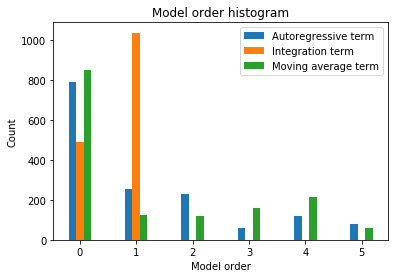

In [17]:
# Visualizing model order frequency
# NOTE: This cell will not work if loading from memory (pmdarima models don't save
# save nicely without pickling)
modelOrder = np.vstack([list(m.order) for m in allModels.values()])
_ = plt.hist(modelOrder, bins=np.arange(0,6,0.5))  # arguments are passed to np.histogram
plt.gca().set_xticks(np.arange(0.25,6.25,1))
plt.gca().set_xticklabels(np.arange(0,6,1))

plt.title("Model order histogram")
plt.legend(['Autoregressive term','Integration term','Moving average term'])
plt.xlabel('Model order')
plt.ylabel('Count')

In [18]:
# Print the summary statistics for the errors of both prediction types. Unsurprisingly, one-step-ahead
# will outperform!
arimaResults['N-step-ahead APE'] = np.abs(arimaResults['Prediction']-arimaResults['Input'])/arimaResults['Input']
arimaResults['One-step-ahead APE'] = np.abs(arimaResults['Rolling Prediction']-arimaResults['Input'])/arimaResults['Input']

# Don't include the COVID period -- just use the OOS test period (12/1/2019 - 3/1/2020)
oosResults = arimaResults.loc[(arimaResults['Date'] >= OOS_DATE) & (arimaResults['Date'] < COVID_START),:]
covidResults = arimaResults.loc[arimaResults['Date'] >= COVID_START,:]

print('Summary of prediction errors:')
print(oosResults[['N-step-ahead APE','One-step-ahead APE']].mean())

Summary of prediction errors:
N-step-ahead APE      41.945817
One-step-ahead APE    11.039697
dtype: float64


In [19]:
# Set the columns you want to plot: some subset of 'N-step-ahead' and 'One-step-ahead'
plot_labels = ['N-step-ahead']

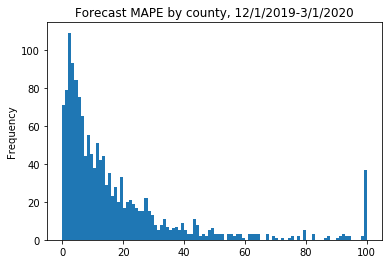

In [20]:
# Histogram of MAPE by region
plot_labels_ape = [s + ' APE' for s in plot_labels]
for c in plot_labels_ape:
    aggByRegion = oosResults.groupby(by='region_id')[[c]].mean()
    aggByRegion.loc[aggByRegion[c]>1,[c]] = 1
    (aggByRegion*100).plot.hist(bins=100, stacked=False)
    plt.title('Forecast MAPE by county, 12/1/2019-3/1/2020')
    plt.gca().get_legend().remove()

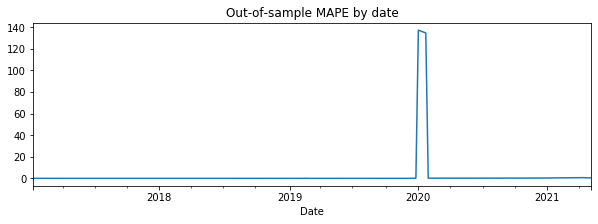

In [21]:
# Time-series of MAPE by date, aggregated across all counties
for c in plot_labels_ape:
    plt.figure()
    arimaResults.groupby(by='Date')[c].mean().plot(figsize=(10,3))
    plt.title('Out-of-sample MAPE by date')

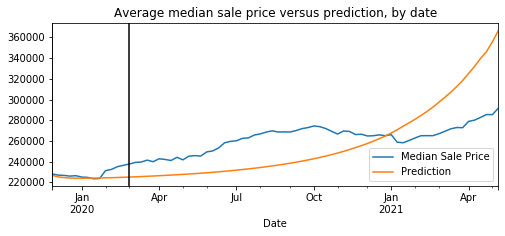

In [22]:
# Average prediction across all counties during the OOS period
plot_labels_fcast = [s + ' Forecast' for s in plot_labels]
for c in plot_labels_fcast:
    lbl = 'Prediction' if c=='N-step-ahead Forecast' else 'Rolling Prediction'
    tmp = arimaResults.loc[arimaResults['Date']>='2019-12-01',:]
    tmp[['Median Sale Price','Prediction']] = tmp[['Input',lbl]]
    tmp.groupby('Date').mean()[['Median Sale Price','Prediction']].plot(figsize=(8,3))
    plt.title('Average median sale price versus prediction, by date')
    plt.axvline(x='2019-12-01',color='k')
    plt.axvline(x='2020-03-01',color='k')